In [1]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

In [194]:
date='2019-05-28'                                                         #新增会员列表
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
df1.head()

,doc_count,id
0,1,161866
1,1,185019
2,1,223445
3,1,231421
4,1,244801


In [195]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,'sources': [{'father_id':{'terms':{'field':'user_parent_list'}}},  #拉取会员数
                                                       {'id': {'terms': {'field': 'id'}}},
                                                        
                                                     ]}}},
          'query': {'bool': {'must': [{'terms':{'user_parent_list':[str(x) for x in df1['id']]}}
                                ]}}}
es_market2 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_market2 = es_market2.search(index='es_user_table', doc_type='user', body=dsl,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
df_market2 = json_normalize(res_market2['aggregations']['my_buckets']['buckets'])
df_market2.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_market2.columns))
df_market2.head()

,doc_count,father_id,id
0,1,175963,836308
1,1,175963,841331
2,1,175963,853788
3,1,176009,840611
4,1,176009,840619


In [196]:
def father_id_list(s):
    data={}
    data['sons'] = s['id'].tolist()
    return pd.Series(data)

df_list = df_market2.groupby('father_id').apply(father_id_list).reset_index()
df_list=df_list.set_index('father_id')
df_list.head()

,sons
father_id,
175963,"[836308, 841331, 853788]"
176009,"[840611, 840619, 840665, 840991, 843579, 846913]"
176309,[892229]
176362,[838247]
176797,"[830312, 835784, 836186, 836264, 837341, 83740..."


In [197]:
length=[]
son_list=[]
for x in bar.progressbar(df1['id']): 
    if x not in df_list.index:
        length.append(0)
        son_list.append([])
    else:
        length.append(len(df_list.loc[x]['sons']))
        son_list.append(df_list.loc[x]['sons'])

df1['长度']=length
df1['下线']=son_list

100% (2608 of 2608) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [198]:
df1.head()

,doc_count,id,长度,下线
0,1,161866,0,[]
1,1,185019,0,[]
2,1,223445,0,[]
3,1,231421,0,[]
4,1,244801,0,[]


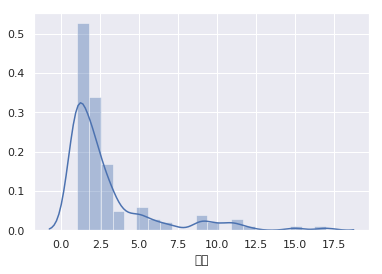

In [199]:
df2=df1[df1['长度']!=0]
df3=df2[df2['长度']<20]
sns.distplot(df3['长度'])

In [200]:
def get_parent_list(s):
    data={}
    data['length_list'] = s['id'].tolist()
    return pd.Series(data)

df_list_1 = df1.groupby('长度').apply(get_parent_list).reset_index()
df_list_1.head()

,长度,length_list
0,0,"[161866, 185019, 223445, 231421, 244801, 26666..."
1,1,"[305433, 314246, 381004, 524791, 532918, 57022..."
2,2,"[764955, 808379, 829272, 835748, 835828, 83584..."
3,3,"[512514, 577996, 835771, 836097, 836472, 83648..."
4,4,"[836326, 836556, 837450, 838648, 839753]"


In [201]:
length_list,active_rate=[],[]
for z in bar.progressbar(df_list_1['length_list']):
    dsl_dead = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [#{"用户ID": {"terms": {"field": 'user_id'}}},
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '8d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                    'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10],
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'user_id': [str(y) for y in z]}},
                        ]}}}
    es_dead = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_dead = es_dead.search(index='shop_pv_event', doc_type='pv_event', body=dsl_dead,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
    df_dead = json_normalize(res_dead['aggregations']['my_buckets']['buckets'])
    df_dead.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_dead.columns))
    if len(df_dead)==0:
        length_list.append(len(z))
        active_rate.append(0)
    else:
        length_list.append(len(z))
        active_rate.append(df_dead.iloc[0]['打开(Visitor).value']/len(z))

100% (19 of 19) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [202]:
df_list_1['访问率']=active_rate
df_list_1['人数']=length_list

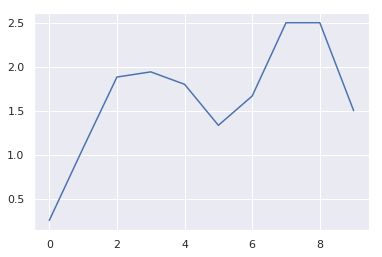

In [203]:
plt.plot(df_list_1.index[0:10],df_list_1['访问率'][0:10])

AB测

朋友间的交流

In [278]:
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

def to_df(res):                                                                       #时间调整
    test_df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    test_df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(test_df.columns))
    test_df['日期'] = test_df['日期'].apply(to_date)
    test_df['日期'] = pd.to_datetime(test_df['日期'])
    #test_df['current_vip_created']= test_df['current_vip_created'].apply(to_date)
    #test_df['current_vip_created']= pd.to_datetime(test_df['current_vip_created'])
    #test_df['购买列表']= test_df['购买列表'].apply(to_date)
    #test_df['购买列表']= pd.to_datetime(test_df['购买列表'])
    return test_df

def get_result(dsl,index,doc_type):
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index=index, doc_type=doc_type, body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
    df = to_df(res)
    return df

date='2019-05-24'

dsl1 = {'aggs': {'my_buckets': { 'aggregations': {'人数': {'cardinality': {'field': 'id'}}},
                                    'composite': {'size': 9999999,
                                       'sources': [{'日期': {'date_histogram': {'field': 'first_vip_created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+00:00'}}},
                                                   {'id': {'terms': {'field': 'id'}}},
                                                  ]}}},
 'query': {'bool': {'must': [    {'terms':{'user_platform':['black_card']}},
                                 {'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=10))[:10],
                                                              'time_zone': '+00:00'}}}
                            ]}}}

df1 = get_result(dsl1,'es_user_table','user')    #新增会员       
df1.head()

,doc_count,id,日期,人数.value
0,1,217038,2019-05-24,1
1,1,226001,2019-05-24,1
2,1,235997,2019-05-24,1
3,1,238216,2019-05-24,1
4,1,240200,2019-05-24,1


In [279]:
def get_list(s):
    data={}
    data['vip_list'] = s['id'].tolist()
    return pd.Series(data)

df_list = df1.groupby('日期').apply(get_list).reset_index()
df_list.head()

,日期,vip_list
0,2019-05-24,"[217038, 226001, 235997, 238216, 240200, 24744..."
1,2019-05-25,"[209450, 210920, 213848, 237955, 245553, 24579..."
2,2019-05-26,"[204184, 212228, 244977, 245491, 247063, 25767..."
3,2019-05-27,"[214657, 235879, 245981, 247487, 252521, 26087..."
4,2019-05-28,"[161866, 185019, 223445, 231421, 244801, 26666..."


In [298]:
#当天行为
baifenbi=[]
bar = progressbar
for i in bar.progressbar(range(len(df_list))):
    dsl = {
                    'query': {'bool': {'must': [
                                                {'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10], 
                                                                       'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10], 
                                                                       'format': 'yyyy-MM-dd', 'time_zone': '+08:00'}}}, 
                                                {'terms':{'user_id': [str(y) for y in df_list.iloc[i]['vip_list']]}},
                                                #{'terms':{'user_id': dead_list}},
                                                {'query_string': {'query': 'skutotal_price != 0'}},
                                                {'terms': {'order_status': ['confirmed',
                                                                            'done',
                                                                            'fulfilled']}},
                                                ]}},
                    "aggs": {
                        "my_buckets": {
                            "composite": {
                                'size': 9999999,
                                "sources": [{'日期': {'date_histogram': {'field': 'paytime', 'interval': '1d', 'time_zone': '+00:00'}}}
                                    ]}} }}
    es_order = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res_order = es_order.search(index='es_order_table', doc_type='order', body=dsl,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df_order = json_normalize(res_order['aggregations']['my_buckets']['buckets'])
    df_order.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_order.columns))
    df_order['日期'] = df_order['日期'].apply(to_date)
    df_order['日期'] = pd.to_datetime(df_order['日期'])
    if len(df_order)==1:
        baifenbi.append(df_order.iloc[0]['doc_count']/len(df_list.iloc[i]['vip_list']))
    else:
        baifenbi.append((df_order.iloc[0]['doc_count']+df_order.iloc[1]['doc_count'])/len(df_list.iloc[i]['vip_list']))
df_list['占比']=baifenbi

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


(array([737204., 737206., 737208., 737210., 737211., 737213.]),
 <a list of 6 Text xticklabel objects>)

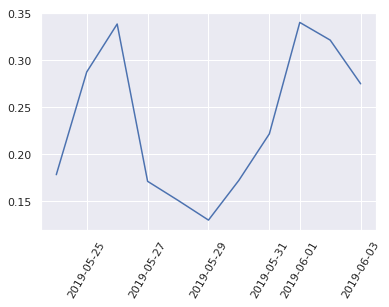

In [300]:
plt.plot(df_list['日期'],df_list['占比'])
plt.xticks(rotation='60')

In [205]:
dsl11 = {
        'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [{"用户ID": {"terms": {"field": 'user_id'}}},
                                           #{'日期': {'date_histogram': {'field': 'created',
                                           #                                   'interval': '1m',
                                           #                                   'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-25',
                                                    'lte': '2019-05-31',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                            # {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': df1['id'].tolist()}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es11 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res11 = es11.search(index='shop_pv_event', doc_type='pv_event', body=dsl11,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df11 = json_normalize(res11['aggregations']['my_buckets']['buckets'])
df11.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df11.columns))

In [206]:
bar = progressbar                                                       #分类依据
active_list,dead_list = [],[]
for i in bar.progressbar(range(len(df11))):
    if df11.iloc[i]['打开(Visitor).value']<5:
        dead_list.append(df11.iloc[i]['用户ID'])
    else:
        active_list.append(df11.iloc[i]['用户ID'])

100% (2032 of 2032) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [253]:
dsl = {'query': {'bool': {'must':   [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-25',
                                                    'lte': '2019-05-31',
                                                    'time_zone': '+08:00'}}},
                                        {'terms':{'user_id': dead_list}},
                                        #{'terms':{'session_scene': ['1007','1008']}},
                                    ]}}, 
         'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                                'composite': {'size': 9999999, 'sources': [{'人': {'terms': {'field': 'user_id'}}},
                                                       #{'场景': {'terms': {'field': 'session_scene'}}},
                                                       #{'日期': {'date_histogram': {'field': 'created',
                                                       #                       'interval': '1d',
                                                       #                       'time_zone': '+08:00'}}} 
                                                                           ]}, 
                                }}}
es_fx = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_fx = es_fx.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_fx = json_normalize(res_fx['aggregations']['my_buckets']['buckets'])
df_fx.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_fx.columns))
#df_fx['日期'] = df_fx['日期'].apply(to_date)
#df_fx['日期'] = pd.to_datetime(df_fx['日期'])
#df_fx['百分比']=df_fx['打开(Visitor).value']/len(active_list)

In [254]:
len(df_fx)

1915

In [255]:
dsl = {'query': {'bool': {'must':   [{'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-25',
                                                    'lte': '2019-05-31',
                                                    'time_zone': '+08:00'}}},
                                        {'terms':{'user_id': dead_list}},
                                        {'terms':{'session_scene': ['1007','1008']}},
                                    ]}}, 
         'aggs': {'my_buckets': {'aggregations': {'打开(Visitor)': {'cardinality': {'field': 'session_id', 'precision_threshold': 100}}},
                                'composite': {'size': 9999999, 'sources': [{'人': {'terms': {'field': 'user_id'}}},
                                                       #{'场景': {'terms': {'field': 'session_scene'}}},
                                                       #{'日期': {'date_histogram': {'field': 'created',
                                                       #                       'interval': '1d',
                                                       #                       'time_zone': '+08:00'}}} 
                                                                           ]}, 
                                }}}
es_fx2 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res_fx2 = es_fx2.search(index='shop_pv_event', doc_type='pv_event', body=dsl,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df_fx2 = json_normalize(res_fx2['aggregations']['my_buckets']['buckets'])
df_fx2.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df_fx2.columns))
#df_fx2['日期'] = df_fx2['日期'].apply(to_date)
#df_fx2['日期'] = pd.to_datetime(df_fx2['日期'])
#df_fx2['百分比']=df_fx2['打开(Visitor).value']/len(dead_list)

In [256]:
len(df_fx2)

454

(array([737203., 737204., 737205., 737206., 737207., 737208., 737209.]),
 <a list of 7 Text xticklabel objects>)

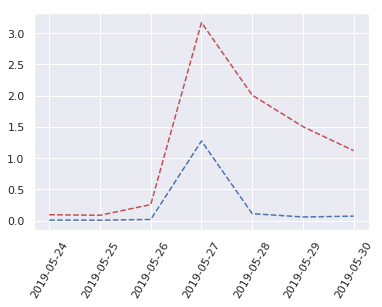

In [237]:
plt.plot(df_fx['日期'],df_fx['百分比'],'r--',
        df_fx2['日期'],df_fx2['百分比'],'b--')
plt.xticks(rotation='60')

In [257]:
len(df_fx2)/len(df_fx)

0.2370757180156658